In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
#df_base = pd.json_normalize(list(json.loads(line) for line in open("/tmp/stellarpunk_test.history", "r")))
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
pd.Series(df_base["eid"].unique())

0     59e69d87-78f2-4b33-902e-52db626e16da
1     266059be-6e18-4b08-81d4-5c2e9b68fffc
2     3c6951c3-fa33-41d9-b0ad-a44f2a6ad65c
3     ca367884-b4a8-4822-8c10-12b8a66b4b63
4     5a0c6512-3415-41bf-91d0-f64a01b76cf0
5     d85f250d-b5df-4c25-95de-c4bfa3bf1500
6     0ee4556e-de0f-4e9f-ba1e-c6841ade0f7a
7     e24afb37-08be-4a85-978a-e22d76944d80
8     2db9e6ba-c0cf-4bf8-86c0-323afc2273b1
9     416e3635-98b5-4129-a2b0-7535ffc5ea62
10    fea792c9-b040-45ef-9135-2847d0fdc1d6
11    b47be085-418b-4ebb-b6d2-395492b6657e
12    b7f21a29-4278-4cb8-89f9-4850e1b053ec
13    b2acebe9-de60-4481-b4dc-655026918cee
14    3afc02f9-40f4-47d2-86da-10066603761c
15    b774243f-6bec-436f-9cd5-020ca2fc9d71
16    294d919e-57e9-42ae-bb98-527dc4208f3b
17    102bf43b-55e7-4ac4-a6fd-7a263100f813
18    f2b88470-7138-4ddb-bbcc-b6480a67cc14
19    bcf039df-ffe6-440f-a0ae-55d8c1a43e12
20    687aa521-6d73-4e7d-9b9a-86bc585b1306
21    3e548a32-51fa-49ea-bda9-2722569eb189
22    8aa6e48a-43c9-43f9-86b4-f78c5697e33a
23    08bc4

In [4]:
target_eid = df_base["eid"].unique()[45]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['5a7d4493-c4c5-4559-b1fa-5e7178016085'], dtype=object)

In [5]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [6]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)

In [7]:
df

,index,eid,ts,loc,a,v,av,o,o.o,o.nnd,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,18040,5a7d4493-c4c5-4559-b1fa-5e7178016085,58.133333,"[20730.00507776424, 21770.739140788522]",0.286937,"[1662.7749483599844, 545.6001018204189]",0.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,19910.267302,...,116125.840777,53072.616597,1662.774948,545.600102,95.911534,28.301547,1750.000000,NaN,100400.064747,1750.0
1,18041,5a7d4493-c4c5-4559-b1fa-5e7178016085,58.150000,"[20757.71799357024, 21779.832475818865]",0.286937,"[1662.7749483599844, 545.6001018204189]",0.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,19888.167363,...,116125.840777,53072.616597,1662.774948,545.600102,95.911534,28.301547,1750.000000,NaN,100370.898080,1750.0
2,18042,5a7d4493-c4c5-4559-b1fa-5e7178016085,58.166667,"[20785.430909376242, 21788.925810849207]",0.286937,"[1662.7749483599844, 545.6001018204189]",0.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,19866.085661,...,116125.840777,53072.616597,1662.774948,545.600102,95.911534,28.301547,1750.000000,NaN,100341.731413,1750.0
3,18043,5a7d4493-c4c5-4559-b1fa-5e7178016085,58.183333,"[20813.143825182244, 21798.019145879545]",0.286937,"[1662.7749483599844, 545.6001018204188]",0.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,19844.022257,...,116125.840777,53072.616597,1662.774948,545.600102,95.911534,28.301547,1750.000000,NaN,100312.564747,1750.0
4,18044,5a7d4493-c4c5-4559-b1fa-5e7178016085,58.200000,"[20840.856740988245, 21807.112480909887]",0.286937,"[1662.7749483599844, 545.6001018204189]",0.000000,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,19821.977210,...,116125.840777,53072.616597,1662.774948,545.600102,95.911534,28.301547,1750.000000,NaN,100283.398080,1750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,21635,5a7d4493-c4c5-4559-b1fa-5e7178016085,118.050000,"[115761.06299594746, 52962.04302549309]",-3.093792,"[964.9596116666611, 319.36323023985733]",0.638465,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,381.168394,...,116125.840777,53072.616597,0.000000,0.000000,-99.885777,-4.778229,1016.434909,NaN,381.168394,0.0
3596,21636,5a7d4493-c4c5-4559-b1fa-5e7178016085,118.066667,"[115777.1456561419, 52967.365745997085]",-3.083151,"[964.9200551243624, 319.3501385985359]",0.626336,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,364.233482,...,116125.840777,53072.616597,0.000000,0.000000,-99.829278,-5.840831,1016.393243,NaN,364.233482,0.0
3597,21637,5a7d4493-c4c5-4559-b1fa-5e7178016085,118.083333,"[115793.22765706065, 52972.68824830706]",-3.072712,"[964.8804985820638, 319.3370469572145]",0.614196,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,347.299817,...,116125.840777,53072.616597,0.000000,0.000000,-99.762868,-6.882605,1016.351576,NaN,347.299817,0.0
3598,21638,5a7d4493-c4c5-4559-b1fa-5e7178016085,118.100000,"[115809.30899870368, 52978.01053242301]",-3.062476,"[964.8409420397651, 319.3239553158931]",0.602044,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",stellarpunk.orders.GoToLocation,330.367484,...,116125.840777,53072.616597,0.000000,0.000000,-99.687187,-7.903460,1016.309909,NaN,330.367484,0.0


# Basic Ship Vitals

## Position and Heading

In [8]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=118.11666666666125, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

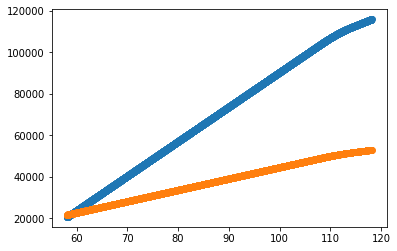

In [9]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

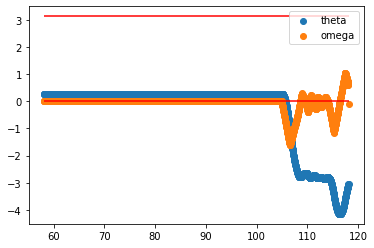

In [10]:

plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()


## Velocity and Acceleration

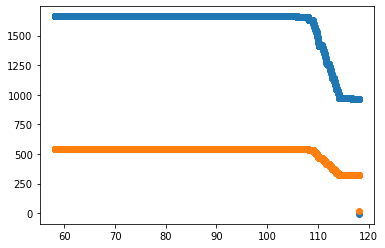

In [11]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

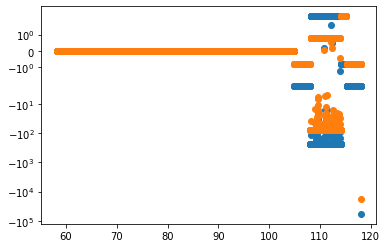

In [12]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")


# Behavior Monitoring

In [13]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_info(hist_length, max_time)>

## Target Location

In [14]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe().sort_values(["min"])
x

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
116125.840777,53072.616597,3600.0,88.125,17.322914,58.133333,73.129167,88.125,103.120833,118.116667


In [15]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"])["o_t_dist"].describe()
x

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
116125.840777,53072.616597,3600.0,48207.163117,29861.449585,313.436586,21671.939747,47914.64808,74157.356413,100400.064747


(313.4365864889512, 313.4365864889512)

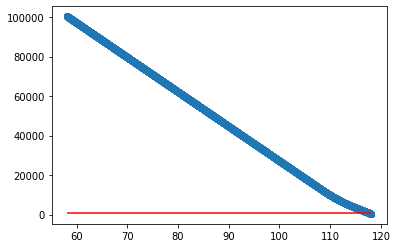

In [27]:
plt.scatter(df["ts"], df["o_t_dist"])
plt.hlines(1000, df["ts"].min(), df["ts"].max(), color="red")
df["o_t_dist"].min(),df[df["ts"] > df["ts"].max()-1]["o_t_dist"].min()

(0.0, 1837.5000000000005)

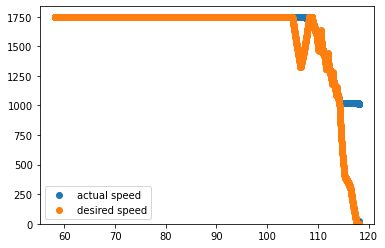

In [28]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)

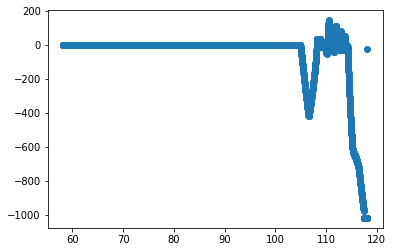

In [18]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

## Collision Avoidance

In [19]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct")["ts"].describe()
else:
    x = "no collision threats"
x

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
4052bf6f-e0d0-4a11-9c30-c6d19b014881,63.0,114.716667,0.305505,114.2,114.458333,114.716667,114.975,115.233333


In [20]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct")["o_ct_dist"].describe()
else:
    x = "no collision threats"
x

,count,mean,std,min,25%,50%,75%,max
o.ct,,,,,,,,
4052bf6f-e0d0-4a11-9c30-c6d19b014881,63.0,3055.130247,338.440699,2479.79046,2769.314956,3056.617347,3342.223542,3622.330205


(0.0, 3788.4467154193862)

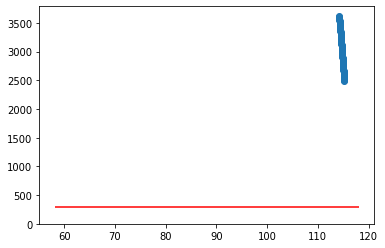

In [21]:
plt.scatter(df["ts"], df["o_ct_dist"])
plt.hlines(300, df["ts"].min(), df["ts"].max(), color="red")
plt.ylim(0)

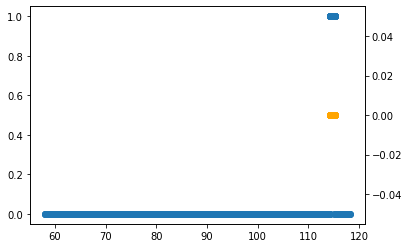

In [22]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

# History Visualization

## Position and Velocity

In [23]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::20]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=118.11666666666125, max_time=118.11666666666125)>

## Position and Heading

In [24]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::20]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=118.11666666666125, max_time=118.11666666666125)>

# 